In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
serial = pd.read_csv("../serial/output/stats.csv")
ompc = pd.read_csv("../ompcluster/output/stats.csv")
mpi = pd.read_csv("../mpi_openmp/output/stats.csv")
gpu = pd.read_csv("../ompcluster/output/stats_gpu.csv")

In [3]:
serial['Implementation'] = 'Serial'
ompc['Implementation'] = 'OMPC'
mpi['Implementation'] = 'MPI + Open MP'
gpu['Implementation'] = 'GPU'

# Concatenate the dataframes
all_data = pd.concat([serial, ompc, mpi, gpu], ignore_index=True)

In [4]:
mapping = {"mnist-1x": 784 , "mnist-2x": 3248 , "mnist-4x": 12544}
all_data['Image Size'] = all_data['Binary'].map(mapping)

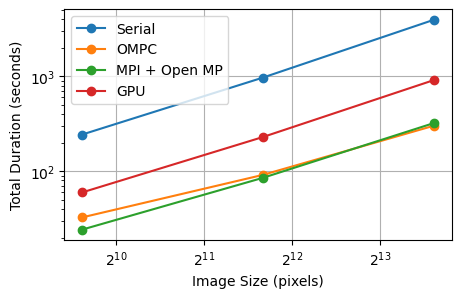

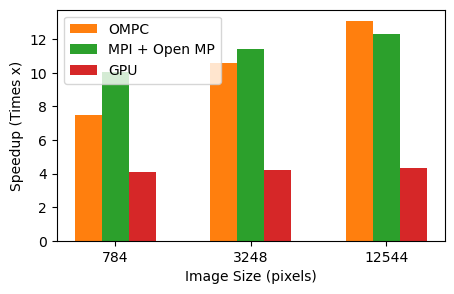

In [5]:
# Filter data for Nodes = 1
filtered_data = all_data[all_data['Nodes'] == 1]

# Create the first plot (scatter plot with exponential axes)
plt.figure(figsize=(5, 3))
for implementation in filtered_data['Implementation'].unique():
    subset = filtered_data[filtered_data['Implementation'] == implementation]
    plt.plot(subset['Image Size'], subset['Total Duration'], marker='o', label=implementation)

plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('Image Size (pixels)')
plt.ylabel('Total Duration (seconds)')
#plt.title('Total Duration vs. Image Size (Nodes = 1)')
plt.legend()
plt.grid(True)
plt.show()


# Create the second plot (bar plot for speedup)
plt.figure(figsize=(5, 3))
implementations = ['OMPC', 'MPI + Open MP', 'GPU']
colors = {'OMPC': 'tab:orange', 'MPI + Open MP': 'tab:green', 'GPU': 'tab:red'}
bar_width = 0.2
x_positions = np.arange(len(filtered_data['Image Size'].unique()))

for i, implementation in enumerate(implementations):
    speedup = []
    for image_size in filtered_data['Image Size'].unique():
        serial_duration = filtered_data[(filtered_data['Image Size'] == image_size) & (filtered_data['Implementation'] == 'Serial')]['Total Duration'].iloc[0]
        try:
            parallel_duration = filtered_data[(filtered_data['Image Size'] == image_size) & (filtered_data['Implementation'] == implementation)]['Total Duration'].iloc[0]
            speedup.append(serial_duration / parallel_duration)
        except IndexError:
            speedup.append(np.nan)
    plt.bar(x_positions + i * bar_width, speedup, width=bar_width, label=implementation, color=colors[implementation])

plt.xticks(x_positions + bar_width, filtered_data['Image Size'].unique())
plt.xlabel('Image Size (pixels)')
plt.ylabel('Speedup (Times x)')
#plt.title('Speedup relative to Serial')
plt.legend(loc="upper left")
plt.show()

In [9]:
all_data = all_data[all_data['Implementation'] != 'GPU']

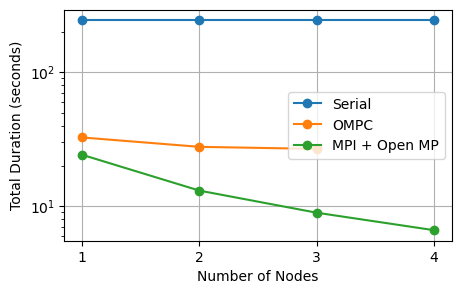

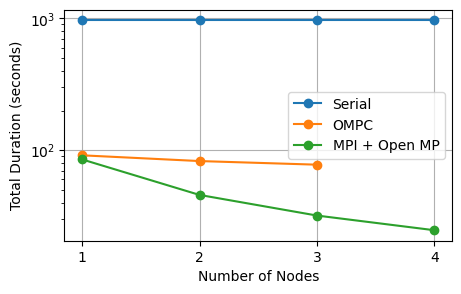

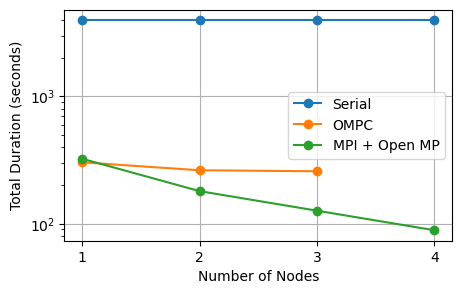

In [10]:
# Create the plot
for image_size in all_data['Image Size'].unique():
    plt.figure(figsize=(5, 3))  # Create a new figure for each image size
    for implementation in all_data['Implementation'].unique():
        subset = all_data[(all_data['Image Size'] == image_size) & (all_data['Implementation'] == implementation)]

        if implementation == 'Serial':
            # Repeat serial data for all node counts
            node_counts = all_data['Nodes'].unique()
            durations = [subset['Total Duration'].iloc[0]] * len(node_counts) # Repeat the serial duration
            plt.plot(node_counts, durations, marker='o', label=implementation)
        else:
            plt.plot(subset['Nodes'], subset['Total Duration'], marker='o', label=implementation)

    plt.xscale('linear')  # Use linear scale for x-axis (number of nodes)
    plt.yscale('log', base=10)  # Keep exponential scale for y-axis (time)
    plt.xlabel('Number of Nodes')
    plt.xticks(range(int(min(all_data['Nodes'])), int(max(all_data['Nodes']))+1))
    plt.ylabel('Total Duration (seconds)')
    #plt.title(f'Total Duration vs. Number of Nodes (Image Size = {image_size} pixels)')
    plt.legend(loc="center right")
    plt.grid(True)
    plt.show()

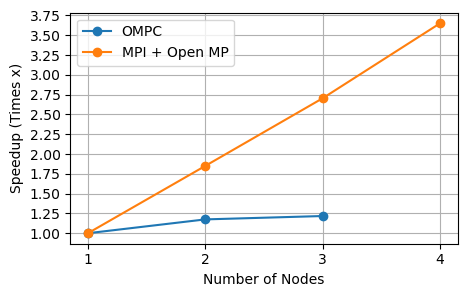

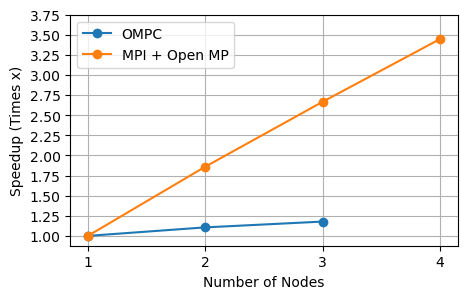

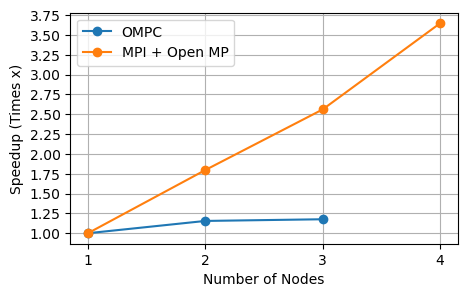

In [8]:
# Create the plot
for image_size in all_data['Image Size'].unique():
    plt.figure(figsize=(5, 3))  # Create a new figure for each image size
    for implementation in all_data['Implementation'].unique():
        subset = all_data[(all_data['Image Size'] == image_size) & (all_data['Implementation'] == implementation)]

        if implementation != 'Serial':
            # Calculate speedup for Nodes > 1
            speedup = []
            nodes = []
            for node_count in subset["Nodes"]:
                if node_count == 1:
                    nodes.append(node_count)
                    previous_duration = subset[subset["Nodes"] == node_count]["Total Duration"].iloc[0]
                    current_duration = subset[subset["Nodes"] == node_count]["Total Duration"].iloc[0]
                    speedup.append(previous_duration / current_duration)
                else:
                    nodes.append(node_count)
                    previous_duration = subset[subset["Nodes"] == 1]["Total Duration"].iloc[0]
                    current_duration = subset[subset["Nodes"] == node_count]["Total Duration"].iloc[0]
                    speedup.append(previous_duration / current_duration)
            plt.plot(nodes, speedup, marker='o', label=implementation)

    plt.xscale('linear')  # Use linear scale for x-axis (number of nodes)
    plt.yscale('linear')  # Use linear scale for y-axis (speedup)
    plt.xlabel('Number of Nodes')
    plt.xticks(range(int(min(all_data['Nodes'])), int(max(all_data['Nodes']))+1))
    plt.yticks(np.arange(1, 4, 0.25))
    plt.ylabel('Speedup (Times x)')
    #plt.title(f'Speedup vs. Number of Nodes (Image Size = {image_size} pixels)')
    plt.legend()
    plt.grid(True)
    plt.show()